# Аналитика в авиакомпании

Имеются данные о количестве рейсов для каждой модели самолёта за сентябрь 2018 года и о среднем количестве рейсов в день для городов за тот же период. Нужно сделать разведочный анализ данных.

## Структура проекта

1. [Начало работы](#start)
3. [Анализ данных](#analisys)
5. [Выводы](#conclusions)

## Начало работы
<a id='start'></a>
<a id='name'></a>

Импортируем нужные библиотеки, считаем данные, ознакомимся с ними.

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import re

In [2]:
sns.set(rc={'figure.figsize':(15,7), 
            'figure.dpi':80,},
        palette = 'colorblind',
        style='ticks')

In [3]:
models = pd.read_csv('https://code.s3.yandex.net/datasets/query_1.csv')
cities = pd.read_csv('https://code.s3.yandex.net/datasets/query_3.csv')

In [4]:
models.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
model             8 non-null object
flights_amount    8 non-null int64
dtypes: int64(1), object(1)
memory usage: 256.0+ bytes


In [5]:
models

,model,flights_amount
0,Airbus A319-100,607
1,Airbus A321-200,960
2,Boeing 737-300,630
3,Boeing 767-300,600
4,Boeing 777-300,300
5,Bombardier CRJ-200,4446
6,Cessna 208 Caravan,4557
7,Sukhoi SuperJet-100,4185


In [6]:
cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 2 columns):
city               101 non-null object
average_flights    101 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.7+ KB


In [7]:
cities.sample(10, random_state=42)

,city,average_flights
84,Ульяновск,9.580645
55,Новый Уренгой,8.290323
66,Псков,1.548387
67,Ростов-на-Дону,10.193548
45,Надым,2.290323
39,Магнитогорск,4.000000
22,Ижевск,1.000000
44,Мурманск,2.000000
10,Брянск,10.000000
0,Абакан,3.870968


На первый взгляд с данными никаких проблем нет - типы данных соответствуют ожидаемым, пропусков нет, столбцы названы нормально.



---



## Разведочный анализ
<a id='analisys'></a>
<a name='analisys'></a>

Посмотрим на разные графики, подумаем, что они значат

Для начала посмотрим на топ-10 городов по рейсам в день:

In [8]:
cities.sort_values('average_flights', ascending=False).head(10)

,city,average_flights
43,Москва,129.774194
70,Санкт-Петербург,31.161290
54,Новосибирск,17.322581
33,Красноярск,11.580645
20,Екатеринбург,11.322581
67,Ростов-на-Дону,10.193548
63,Пермь,10.129032
10,Брянск,10.000000
74,Сочи,9.612903
84,Ульяновск,9.580645


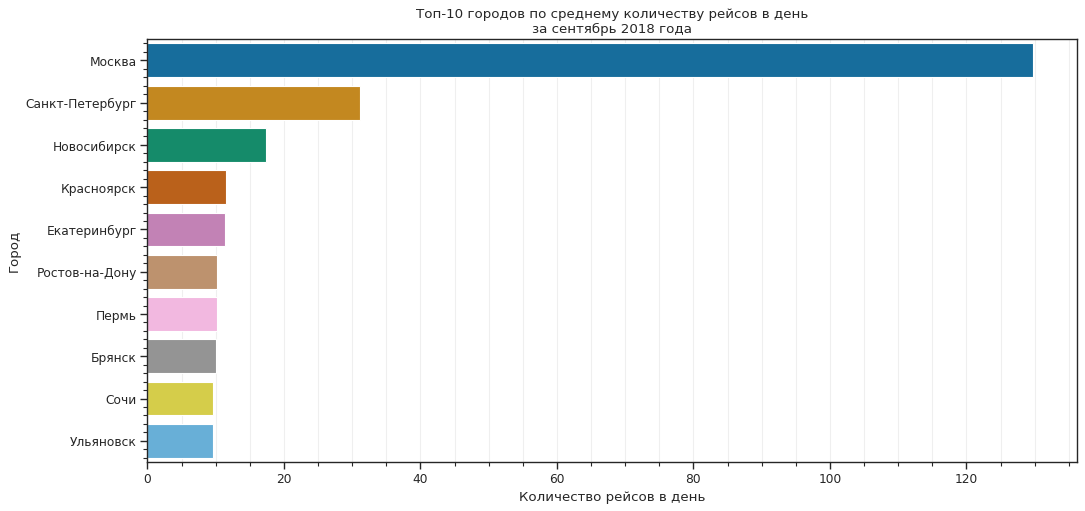

In [9]:
sns.barplot(
    data = cities.sort_values('average_flights', ascending=False).head(10),
    y = 'city',
    x = 'average_flights',
    ci = None,
)

plt.minorticks_on()
plt.grid(which='both', axis='x', alpha=.3)

plt.title('Топ-10 городов по среднему количеству рейсов в день\nза сентябрь 2018 года')
plt.xlabel('Количество рейсов в день')
plt.ylabel('Город')

plt.show()

А так же сразу на все города:

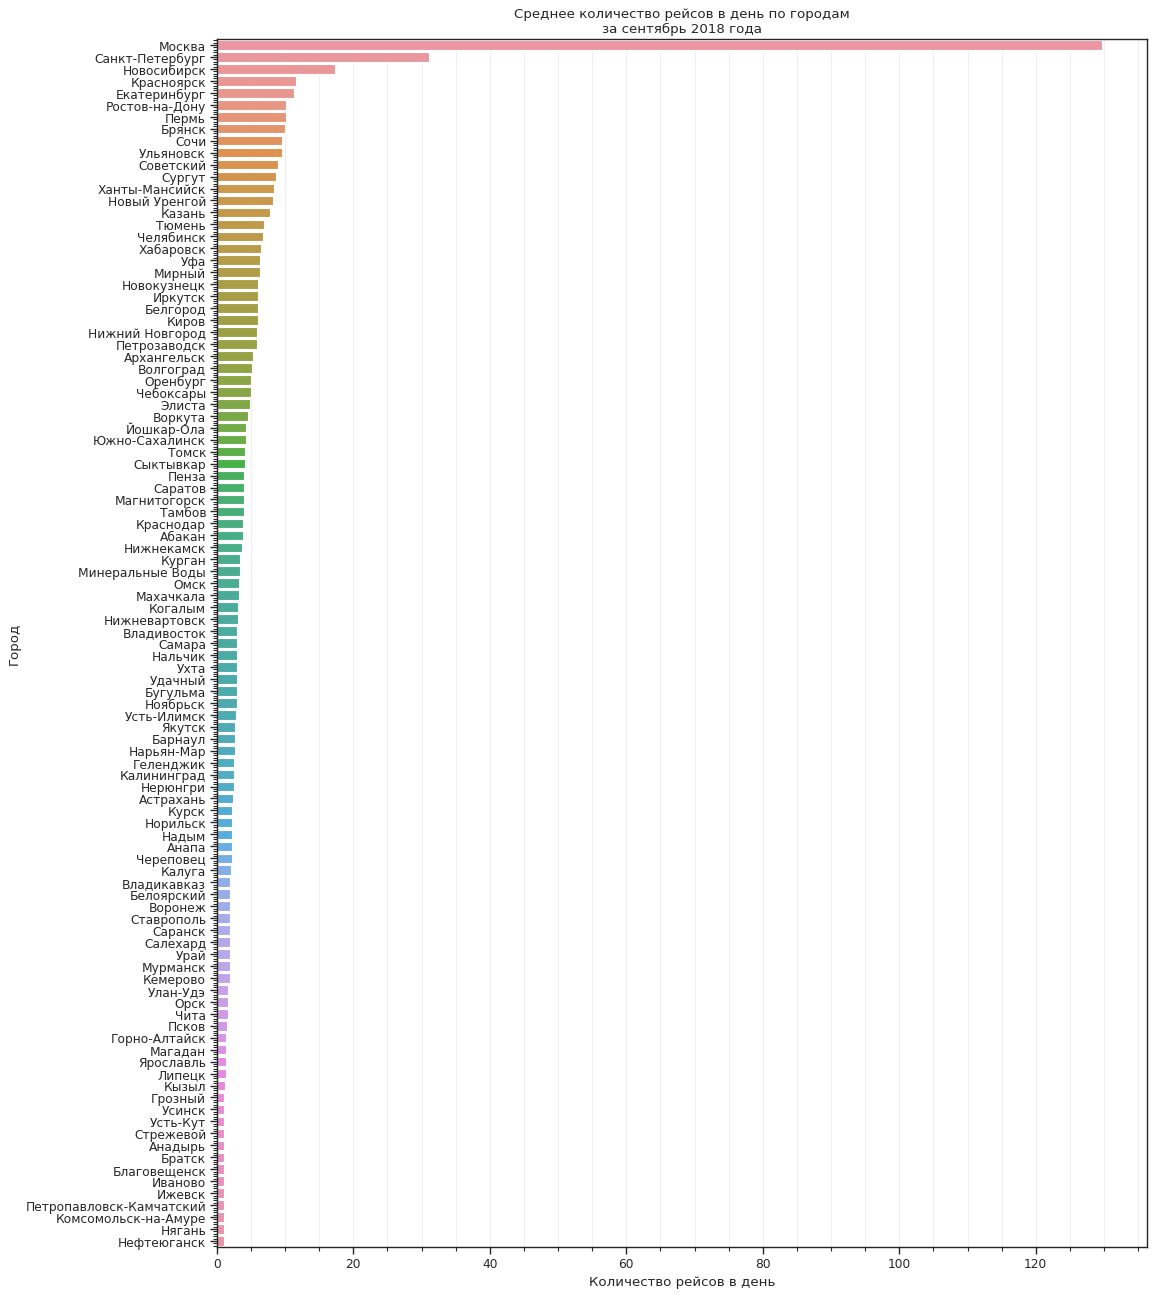

In [23]:
plt.figure(figsize=(15, 20))
sns.barplot(
    data = cities.sort_values('average_flights', ascending=False),
    y = 'city',
    x = 'average_flights'
)
plt.minorticks_on()
plt.grid(which='both', axis='x', alpha=.3)

plt.title('Среднее количество рейсов в день по городам\nза сентябрь 2018 года')
plt.xlabel('Количество рейсов в день')
plt.ylabel('Город')
plt.show()

На графиках видно, что в топ-10 городов, ожидаемо, попали Москва, Санкт-Петербург и Новосибирск. После этих трёх городов видно небольшую ступеньку, и дальше таких резких перепадов уже не наблюдается.

Посмотрим на количество рейсов по моделям самолётов:

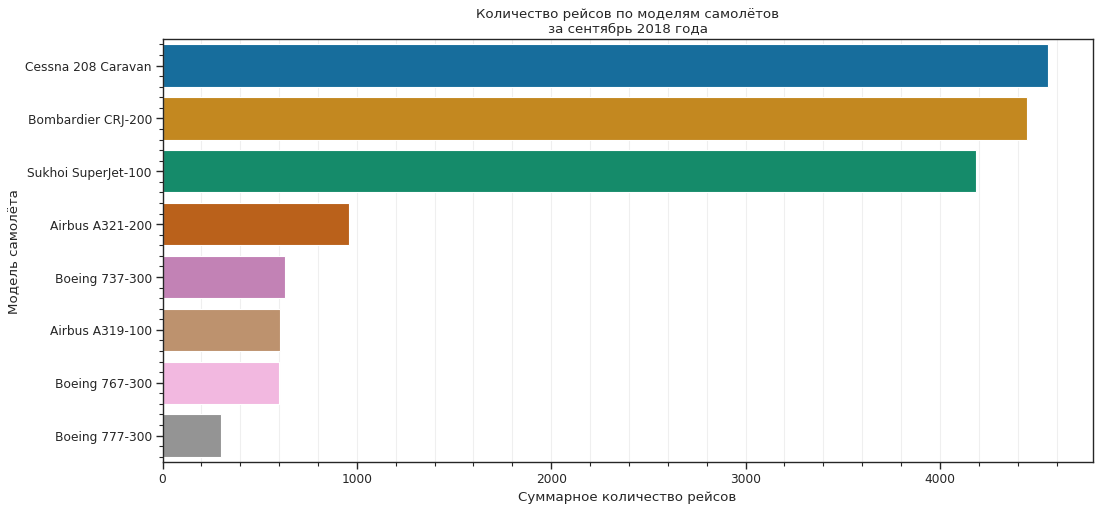

In [10]:
sns.barplot(
    data = models.sort_values('flights_amount', ascending=False),
    y = 'model',
    x = 'flights_amount',
    ci = None,
)

plt.minorticks_on()
plt.grid(which='both', axis='x', alpha=.3)

plt.title('Количество рейсов по моделям самолётов\nза сентябрь 2018 года')
plt.xlabel('Суммарное количество рейсов')
plt.ylabel('Модель самолёта')

plt.show()

Видно, что есть огромный перепад в количестве рейсов между первыми тремя моделями и остальными. Если поискать информацию о количестве пассажиров и дальности перелётов, становится понятно, что первые модели являются небольшими самолётами для местных рейсов, тогда как последние модели являются серьёзными самолётами для межконтинентальных перелётов. 

Посмотрим так же и на численность городов. Для этого спарсим нужные данные с википедии:

In [11]:
cities['population'] = np.nan

for city in cities['city']:
    URL = f'https://ru.wikipedia.org/wiki/{city}'
    req = requests.get(URL).text
    soup = BeautifulSoup(req, 'lxml')
    table = soup.find('table', attrs={'class': 'infobox'})
    try:
        for span in table.find_all('span', attrs={'data-wikidata-property-id': "P1082"}):
            population = re.search(r'[\d ]+', span.text.replace(u'\xa0', '')).group()
            cities.loc[cities['city'] == city, 'population'] = int(population)
    except:
        pass

In [12]:
cities.sort_values('average_flights', ascending=False).head(10)

,city,average_flights,population
43,Москва,129.774194,12655050.0
70,Санкт-Петербург,31.161290,5384342.0
54,Новосибирск,17.322581,1625631.0
33,Красноярск,11.580645,1093771.0
20,Екатеринбург,11.322581,1493749.0
67,Ростов-на-Дону,10.193548,1137904.0
63,Пермь,10.129032,1055397.0
10,Брянск,10.000000,402675.0
74,Сочи,9.612903,443562.0
84,Ульяновск,9.580645,627705.0


In [13]:
cities.corr()

,average_flights,population
average_flights,1.000000,0.961232
population,0.961232,1.000000


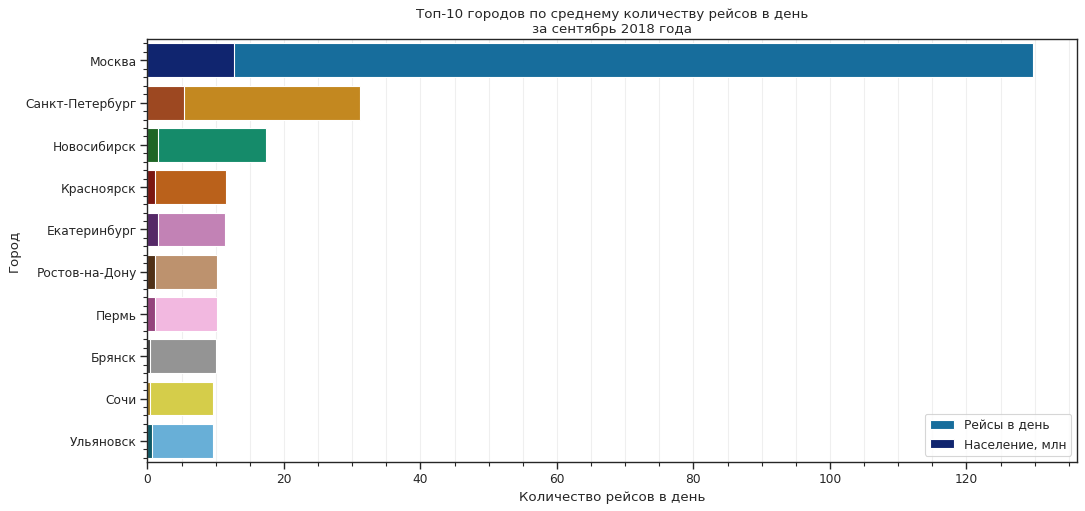

In [14]:
cities['population_mln'] = cities['population'] / 1000000
sns.barplot(
    data = cities.sort_values('average_flights', ascending=False).head(10),
    y = 'city',
    x = 'average_flights',
    label = 'Рейсы в день'
)

sns.barplot(
    data = cities.sort_values('average_flights', ascending=False).head(10),
    y = 'city',
    x = 'population_mln',
    palette = 'dark',
    label = 'Население, млн'
)

plt.minorticks_on()
plt.grid(which='both', axis='x', alpha=.3)

plt.title('Топ-10 городов по среднему количеству рейсов в день\nза сентябрь 2018 года')
plt.xlabel('Количество рейсов в день')
plt.ylabel('Город')

plt.legend()
plt.show()



---



## Выводы
<a id='conclusions'></a>
<a name='conclusions'></a>

Подведём итоги

Внимательно изучив графики и добытую информацию, можно сделать следующие выводы:
- На количество рейсов в день почти напрямую влияет численность населения города (уровень корреляции 0.96 это довольно много), что видно по последнему графику.
- Такая большая разница в количестве рейсов у разных моделей самолётов объясняется, скорее всего, их вместимостью (у модели с самым маленьким количеством рейсов вместимость порядка 400 человек, тогда как у модели с самым большим количеством - всего 14). Данных недостаточно, чтобы подтвердить это, но можно сделать предположение, что модели с большей вместимостью летают в основном в большие города, тогда как небольшие модели летают в основном по непопулярным маршрутам в небольшие города.
- Такое большое количество ежедневных рейсов в Москве (и малое в Сочи) можно объяснить окончанием сезона отпусков (сентябрь как-раз), но данных, опять же, недостаточно. Чтобы это подтвердить было бы неплохо проанализировать не только пункт назначения, но и место вылета, хотя бы.


В итоге получается, что делать какие-то серьёзные выводы по имеющейся у нас информации не получается, так как информации довольно мало. Можно сформулировать некоторые гипотезы, но ни опровергнуть, ни доказать их мы не сможем.